# Intro

https://www.kaggle.com/c/learn-together

My attempt at the contest, upvoted kernels, which I found useful.

# Versioning

* Version: V1
* Description: 
  - Initial attempt with hyperparameter optimization

In [1]:
dir = !ls -a
if ('kernel-metadata.json' in dir):
    src = 'Local'
    # Local environment
    data_path = './data/learn-together'
else:
    # Kaggle environment
    src = 'Kaggle'
    data_path = '../input'

print('Environment set to [{env}]'.format(env=src))

Environment set to [Local]


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [3]:
# Suppress future defaults warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# System imports
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Utilities
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [4]:
grid_search = 1
generate_output = 1

In [5]:
df_test = pd.read_csv(data_path + '/test.csv')
df_sample_submission = pd.read_csv(data_path + '/sample_submission.csv')
df = pd.read_csv(data_path + '/train.csv')
df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [6]:
# Identify columns with only 1 value, these are unlikely to be helpful
col_singular = [col for col in df.columns if df[col].nunique() == 1]
print('Singular columns: {}'.format(col_singular))

# Drop singular columns
df.drop(col_singular, axis=1, inplace=True)
df_test.drop(col_singular, axis=1, inplace=True)

Singular columns: ['Soil_Type7', 'Soil_Type15']


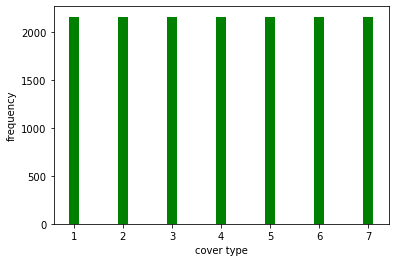

In [7]:
# Check if target types are evenly spread
plt.ylabel('frequency')
plt.xlabel('cover type')
plt.bar(df['Cover_Type'].unique(), df['Cover_Type'].value_counts(), color ='green', width=0.2)
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

# Evenly distributed, that's great**

In [8]:
# Separate features and target
target = 'Cover_Type'
features = list(df.columns)
features.remove(target)

X = df[features]
y = df[target]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, train_size=0.8)

In [9]:
# Determine which models to evaluate
models = [(DecisionTreeClassifier(random_state=10), True)
          , (RandomForestClassifier(random_state=10), True)
          , (XGBClassifier(random_state=10), True)]

In [10]:
# Function to get initial scores list of models
def get_init_scores(models: list) -> list:
    scores = []
    for model, flag in models:
        if flag:
            score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
            new_score = {'model': model, 'score': score}
            scores.append(new_score)
    return scores

In [ ]:
scores = get_init_scores(models)

In [18]:
for model_score in sorted(scores, key=lambda x: x['score'], reverse=True):
    print('Model: [{model}]\nScore: [{score:.4f}]\n'.format(model=model_score['model'].__class__.__name__,score=model_score['score']))
    

Model: [RandomForestClassifier]
Score: [0.8342]

Model: [DecisionTreeClassifier]
Score: [0.7726]

Model: [XGBClassifier]
Score: [0.7692]



In [20]:
# Random forest gave the best initial result. Will tune it further
# Do a grid search for different combinations

grid_search_results = []
model = RandomForestClassifier(criterion='gini',random_state=10)
n_splits = 10
kfold = KFold(n_splits=n_splits, shuffle=True)
pipeline = Pipeline(steps=[('model', model)])
best_model = copy.deepcopy(model)

if grid_search:
    parameters = {}
    parameters['model__n_estimators'] = [100, 150, 200, 400, 600, 800, 1000, 1100]
    print(parameters)
    
    CV = GridSearchCV(pipeline, param_grid=parameters, scoring = 'accuracy', n_jobs=-1, cv=kfold)
    CV.fit(X_train, y_train)   
    
    best_model = CV.best_estimator_
    print('Best score and parameter combination = ')
    print(CV.best_score_)    
    print(CV.best_params_) 

{'model__n_estimators': [100]}
Best score and parameter combination = 
0.8671461640211641
{'model__n_estimators': 100}


In [23]:
# Test against holdout set
best_model.fit(X_train, y_train)
preds = best_model.predict(X_val)
score = accuracy_score(y_val, preds)
print(score)

0.8693783068783069


In [24]:
# Final output
if generate_output:
    preds = best_model.predict(df_test)

    # Save test predictions to file
    output = pd.DataFrame({'Id': df_sample_submission.Id,
                       'Cover_Type': preds})
    output.head()
    output.to_csv('submission.csv', index=False)